## Eigenvector centrality

Question: How did eigenvector centrality get its name?

For this example, we will use the ["karate club"](https://en.wikipedia.org/wiki/Zachary%27s_karate_club) graph that is included with Networkx.


In [2]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns

<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject


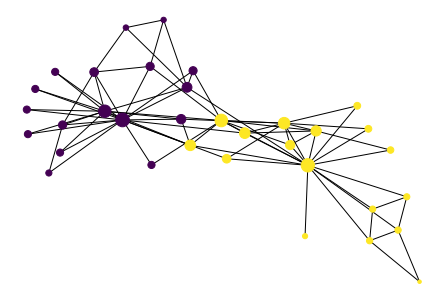

In [3]:
# use the "karate club" graph

kc = nx.karate_club_graph()
kc_info = pd.DataFrame({'clubs': [kc.nodes[i]['club'] for i in kc.nodes]})
kc_info['club_color'] = (kc_info['clubs'] == 'Mr. Hi').astype(int)
kc_ec = nx.eigenvector_centrality(kc)
kc_info['ec'] = np.array([kc_ec[i] for i in kc_ec])

# draw with size proportional to eigvenctor centrality
scaling=500
layout = nx.spring_layout(kc)
nx.draw(kc, pos=layout,node_size=kc_info['ec']*scaling, node_color=kc_info['club_color'])

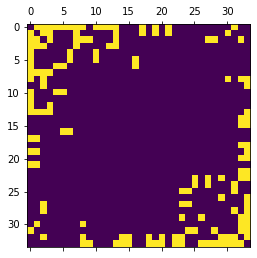

In [4]:
# get adjacency for KC network

kc_adj = nx.to_numpy_array(kc)
plt.matshow(kc_adj)

A relative centrality measure $x_v$ for vertex $v$ can be created according to the following equation:

$$
x_v = \frac{1}{\lambda}\sum_{t \in G}{a_{v,t}*x_t}
$$

where $a$ is the adjacency matrix for the graph $G$ and $\lambda$ is a constant.  That is, a nodes relatively centrality is the sum of all of its neighbors centralities.  It turns out that this can be written in matrix form as:

$$
Ax = \lambda x
$$

which is simply the eigenvector equation (where $\lambda$ are the eigenvalues and $x$ are the eigenvectors).

In [5]:
eigvals, eigvecs = np.linalg.eig(kc_adj)
# the results have very tiny imaginary parts - get rid of those
eigvals = np.real(eigvals)
eigvecs = np.real(eigvecs)


The eigenvector centrality measure is simply the magnitude of the largest eigenvector.

In [6]:
largest_eigvec = eigvecs[:, np.argmax(eigvals)]
np.corrcoef(largest_eigvec, kc_info['ec'])

array([[1., 1.],
       [1., 1.]])

Another way to think about eigenvector centrality is that it reflects the probability of landing on any vertex when one randomly walks through a graph.  Let's simulate this and see.

In [61]:
nsteps = 50000

visit_counts = pd.DataFrame({'n': np.zeros(len(kc.nodes))},
                            index=kc.nodes)
n = np.random.choice(list(kc.nodes)) # starting node
for i in range(nsteps):
    e = list(kc.edges(n))
    r = np.random.randint(len(e))
    n = e[r][1]
    visit_counts.loc[n, 'n'] += 1

In [62]:
np.corrcoef(visit_counts.n, kc_info['ec'] )

array([[1.       , 0.9180177],
       [0.9180177, 1.       ]])

## Estimating centralities

Question: Are there efficient methods to numerically estimate the centrality measures (for instance betweenness centrality)? Or do we have to combinatorially find all paths?


To address this, first let's generate a large network and see how long it takes to compute each kind of centrality.

### Betweeness centrality

Betweeness centrality is a measure of the proportion of shortest paths between all nodes that pass through a given nodes. This requires computation of all shortest paths, so let's first see how long that takes. 

In [7]:
start = time.time()
sp = dict(nx.all_pairs_shortest_path(kc))
print('Elapsed time (secs):', time.time() - start)



Elapsed time (secs): 0.005060911178588867


In [9]:
p = 0.1
shortest_path_time = pd.DataFrame({'n': [i for i in range(10, 1020, 20)]})

for i in shortest_path_time.index:
    Gsim = nx.fast_gnp_random_graph(shortest_path_time.loc[i, 'n'], p)
    start = time.time()
    _ = dict(nx.all_pairs_shortest_path(Gsim))
    shortest_path_time.loc[i, 'et'] = time.time() - start
    

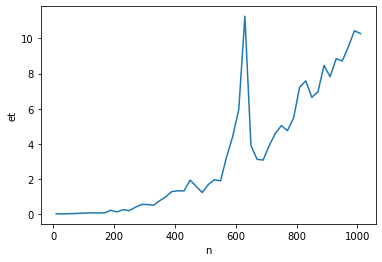

In [33]:
sns.lineplot('n', 'et', data=shortest_path_time)


0.012003183364868164


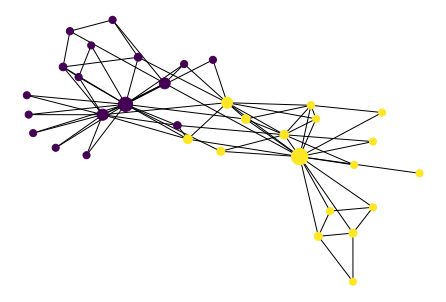

In [211]:
start = time.time()
bc = nx.betweenness_centrality(kc)
print(time.time() - start)

kc_info['bc'] = np.array([bc[i] for i in bc])
nx.draw(kc, pos=layout,node_size=kc_info['bc']*scaling + 50, node_color=kc_info['club_color'])

### Degree centrality

Degree centrality is simply the degree of each node.

0.00021719932556152344


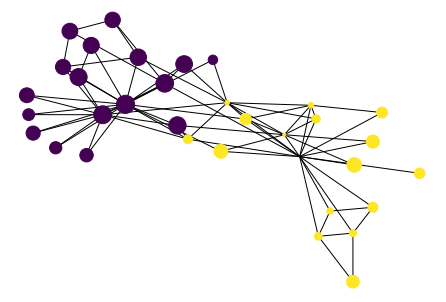

In [212]:
start = time.time()
dc = list(nx.degree_centrality(kc))
print(time.time() - start)

dc_vec = np.array([dc[i] for i in dc])
scaling=10
nx.draw(kc, pos=layout,node_size=dc_vec*scaling, node_color=kc_info['club_color'])

### Closeness centrality

Closeness centrality is the total distance from a node to all other nodes via the shortest path.

0.014991998672485352


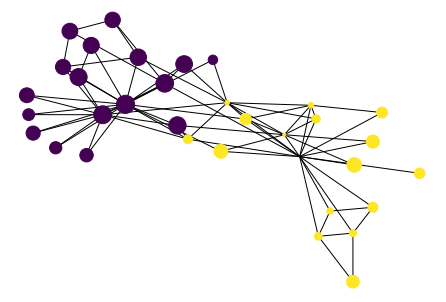

In [214]:
start = time.time()
cc = list(nx.closeness_centrality(kc))
print(time.time() - start)

cc_vec = np.array([cc[i] for i in cc])
nx.draw(kc, pos=layout,node_size=cc_vec*scaling, node_color=kc_info['club_color'])

## Clustering using eigenvectors

We can also use eigendecomposition to cluster a graph -- this is often known as "spectral clustering".


While we could work with the adjacency matrix, it is more common to use the [Laplacian matrix](https://samidavies.wordpress.com/2016/09/20/whats-up-with-the-graph-laplacian/), which you can think of as describing the flow of some quantity away from any particular node in the graph.  The Laplacian L is defined as:

$$
L = D - A
$$ 

where $A$ is the adjacency matrix, and $D$ is a diagonal matrix where each entry is the degree of that particular node. First let's look at this for a simple graph:

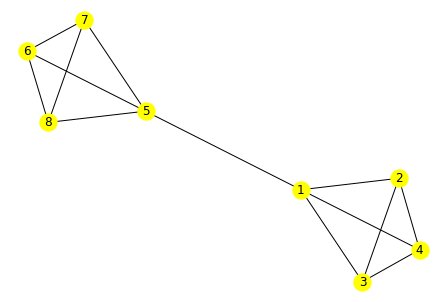

In [34]:
G = nx.Graph()
# nodes 1-4 are members of one community, and 5-8 are members of another, with 1 and 5 connected as well
edges = [(1, 2), (1, 3), (1, 4), (1, 5), (5, 6), (5, 7), (5, 8), 
         (6, 7), (6, 8), (7, 8), (2, 3), (2, 4), (3, 4)]
G.add_edges_from(edges)

nx.draw_spring(G, with_labels=True, node_color='yellow')
A = nx.to_numpy_array(G)


In [36]:
m = len(G.edges)
k = [G.degree[i] for i in G.nodes] # degree values
D = np.zeros(A.shape)
D[np.diag_indices_from(D)] = k
L = D - A
print(L)

[[ 4. -1. -1. -1. -1.  0.  0.  0.]
 [-1.  3. -1. -1.  0.  0.  0.  0.]
 [-1. -1.  3. -1.  0.  0.  0.  0.]
 [-1. -1. -1.  3.  0.  0.  0.  0.]
 [-1.  0.  0.  0.  4. -1. -1. -1.]
 [ 0.  0.  0.  0. -1.  3. -1. -1.]
 [ 0.  0.  0.  0. -1. -1.  3. -1.]
 [ 0.  0.  0.  0. -1. -1. -1.  3.]]


In general, it's more useful to work with the normalized Laplacian, which normalizes by degree. We can compute this easily using linear algebra:

$$
Ln = D^{-\frac{1}{2}}LD^{-\frac{1}{2}}
$$

In [37]:
Ln = np.linalg.inv(np.sqrt(D)).dot(L).dot(np.linalg.inv(np.sqrt(D)))
print(Ln)

[[ 1.         -0.28867513 -0.28867513 -0.28867513 -0.25        0.
   0.          0.        ]
 [-0.28867513  1.         -0.33333333 -0.33333333  0.          0.
   0.          0.        ]
 [-0.28867513 -0.33333333  1.         -0.33333333  0.          0.
   0.          0.        ]
 [-0.28867513 -0.33333333 -0.33333333  1.          0.          0.
   0.          0.        ]
 [-0.25        0.          0.          0.          1.         -0.28867513
  -0.28867513 -0.28867513]
 [ 0.          0.          0.          0.         -0.28867513  1.
  -0.33333333 -0.33333333]
 [ 0.          0.          0.          0.         -0.28867513 -0.33333333
   1.         -0.33333333]
 [ 0.          0.          0.          0.         -0.28867513 -0.33333333
  -0.33333333  1.        ]]


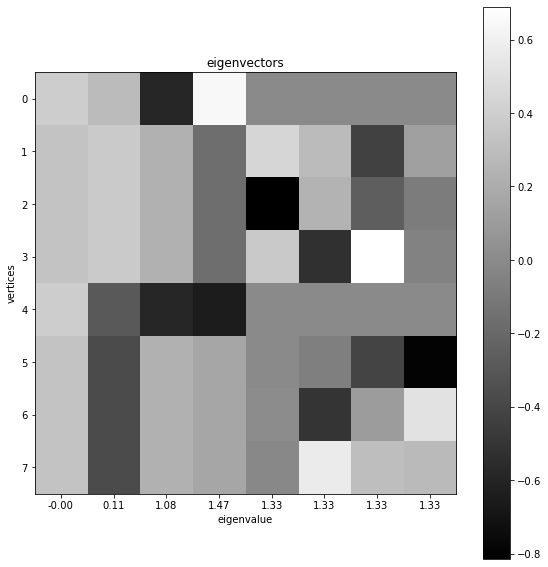

In [44]:
eig = np.linalg.eig(Ln)
def plot_eig(eig, cmap='gray'):
    plt.figure(figsize=(8, 8))
    plt.imshow(eig[1], cmap=cmap)       # Get locations and labels
    _=plt.xticks([i for i in range(len(eig[0]))], ['%0.2f' % i for i in eig[0]])
    plt.xlabel('eigenvalue')
    plt.ylabel("vertices")
    plt.title('eigenvectors')
    plt.colorbar()
    plt.tight_layout()
    
plot_eig(eig, cmap='gray')

Note that there is a single zero eigenvalue, which represents the fact that there is a single graph component.  Another way to say this is that the number of connected components is the same as the dimension of the null space of the Laplacian matrix.


Let's see what would happen if we were to add another component:

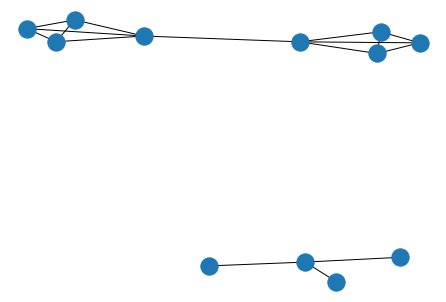

In [39]:
G_bigger = G.copy()
G_bigger.add_edges_from([(9, 10), (10, 11), (10, 12)])
nx.draw_spring(G_bigger)

Now let's get the Laplacian matrix (this time using the built-in NetworkX function) and compute its eigenvalues.

In [40]:
Ln_bigger = nx.normalized_laplacian_matrix(G_bigger).todense()
eig_bigger = np.linalg.eig(Ln_bigger)
eig_bigger[0]

array([-2.77555756e-17,  1.13382475e-01,  1.08333333e+00,  1.46995086e+00,
        1.33333333e+00,  1.33333333e+00,  1.33333333e+00,  1.33333333e+00,
        2.00000000e+00,  1.00000000e+00, -1.00275610e-16,  1.00000000e+00])

Here you can see that there are two zero-valued eigenvalues, reflecting the fact that there are two components.

Now look back at the second column in the eigenvector matrix above, corresponding to the second largest eigenvalue.  Let's draw the graph and color the nodes according to the values of this second smallest eigenvalue:

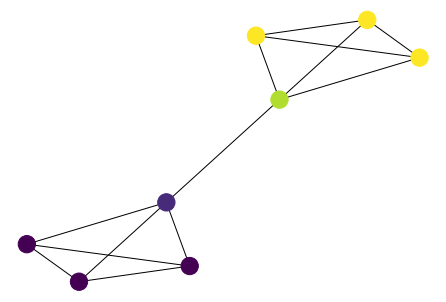

In [41]:
nx.draw_spring(G, node_color=eig[1][:, 1], cmap='viridis')